In [1]:
%run ../input/python-recipes/radial_gradient_header.py
%radial_gradient_header Code Modules & Helpful Functions

In [2]:
import warnings; warnings.filterwarnings('ignore')
import os,urllib,cv2,tensorflow_hub as hub
import numpy as np,tensorflow as tf,pylab as pl
import PIL.Image,time
from IPython.display import display,HTML,clear_output
from IPython.core.magic import register_line_magic
file_path='https://olgabelitskaya.gitlab.io/images/'
tfhub_path='https://tfhub.dev/google/magenta/'+\
           'arbitrary-image-stylization-v1-256/2'
os.environ['TFHUB_MODEL_LOAD_FORMAT']='COMPRESSED'

In [3]:
def get_file(file,file_path=file_path):
    input_file=urllib.request.urlopen(file_path+file)
    output_file=open(file,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
def load_img(path_to_img):
    max_dim=512
    img=tf.io.read_file(path_to_img)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    long_dim=max(shape)
    scale=max_dim/long_dim
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    img=img[tf.newaxis,:]
    return img
def tensor2img(tensor):
    tensor=tensor*255
    tensor=np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1
        tensor=tensor[0]
    return PIL.Image.fromarray(tensor)
def display_images(original_img,style_img,
                   file_path=file_path):    
    fig=pl.figure(figsize=(10,5))
    ax=fig.add_subplot(121)
    str1='Shape of the original image: %s'
    pl.title(str1%str(original_img.shape),fontsize=int(8))
    ax.imshow(np.squeeze(original_img))
    ax=fig.add_subplot(122)
    str2='Shape of the style image: %s'
    pl.title(str2%str(style_img.shape),fontsize=int(8))
    ax.imshow(np.squeeze(style_img))
    pl.tight_layout(); pl.show()
def item_stats(item):
    for name,output in item:
        print(name)
        print('  shape: ',output.numpy().shape)
        print('  min: ',output.numpy().min())
        print('  max: ',output.numpy().max())
        print('  mean: ',output.numpy().mean())
        print(30*'-')

In [4]:
%radial_gradient_header Image Data

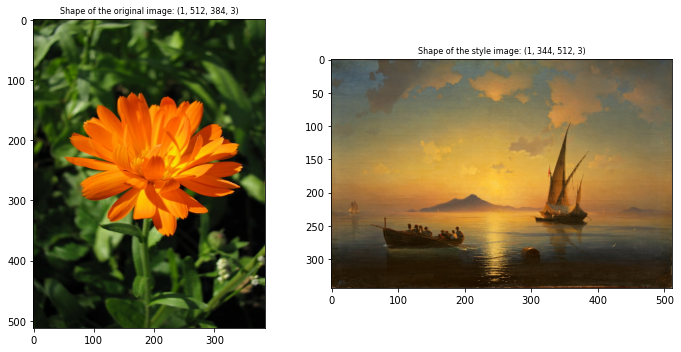

In [5]:
original,style='01_004.png','06_001.png'
for f in [original,style]: get_file(f)
original_img=load_img(original)
style_img=load_img(style)
display_images(original_img,style_img)

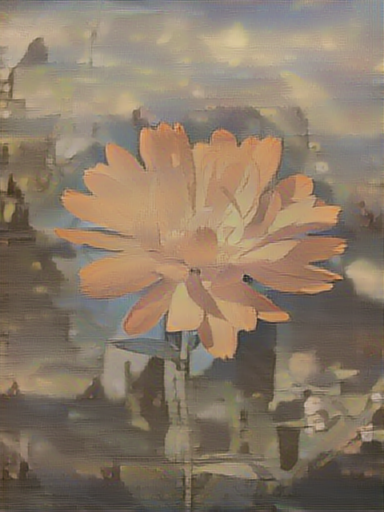

In [6]:
hub_model=hub.load(tfhub_path)
stylized_img=hub_model(
    tf.constant(original_img),tf.constant(style_img))[0]
tensor2img(stylized_img)

In [7]:
%radial_gradient_header Keras Applications

In [8]:
vgg19=tf.keras.applications.VGG19(
    include_top=False,weights='imagenet')
layers=[]
for layer in vgg19.layers:
    layers+=[layer.name]
print(layers)
original_layers=['block5_conv2'] 
style_layers=['block1_conv1','block2_conv1',
              'block3_conv1','block4_conv1','block5_conv1']
num_original_layers=len(original_layers)
num_style_layers=len(style_layers)

80142336/80134624 [==============================] - 1s 0us/step
['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


In [9]:
def vgg_layers(layer_names):
    vgg19=tf.keras.applications.VGG19(
        include_top=False,weights='imagenet')
    vgg19.trainable=False
    outputs=[vgg19.get_layer(name).output 
             for name in layer_names]
    model=tf.keras.Model([vgg19.input],outputs)
    return model

In [10]:
%radial_gradient_header Style Extracting

In [11]:
style_extractor=vgg_layers(style_layers)
style_outputs=style_extractor(style_img*255)
item_stats(zip(style_layers,style_outputs))

block1_conv1
  shape:  (1, 344, 512, 64)
  min:  0.0
  max:  598.4018
  mean:  23.428993
------------------------------
block2_conv1
  shape:  (1, 172, 256, 128)
  min:  0.0
  max:  2431.6785
  mean:  99.13699
------------------------------
block3_conv1
  shape:  (1, 86, 128, 256)
  min:  0.0
  max:  4361.2534
  mean:  77.13981
------------------------------
block4_conv1
  shape:  (1, 43, 64, 512)
  min:  0.0
  max:  9432.584
  mean:  351.87906
------------------------------
block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  2269.7073
  mean:  27.958862
------------------------------


In [12]:
def gram_matrix(input_tensor):
    result=tf.linalg.einsum(
        'bijc,bijd->bcd',input_tensor,input_tensor)
    input_shape=tf.shape(input_tensor)
    num_locations=tf.cast(
        input_shape[1]*input_shape[2],tf.float32)
    return result/(num_locations)

In [13]:
class StyleOriginalModel(tf.keras.models.Model):
    def __init__(self,style_layers,original_layers):
        super(StyleOriginalModel,self).__init__()
        self.vgg=vgg_layers(style_layers+original_layers)
        self.style_layers=style_layers
        self.original_layers=original_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False
    def call(self,inputs):
        inputs=inputs*255.0
        preprocessed_input=\
        tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs=self.vgg(preprocessed_input)
        style_outputs,original_outputs=\
        (outputs[:self.num_style_layers],
        outputs[self.num_style_layers:])
        style_outputs=[gram_matrix(style_output)
                       for style_output in style_outputs]
        original_dict={original_name:value for original_name,value 
                       in zip(self.original_layers,original_outputs)}
        style_dict={style_name:value for style_name,value
                    in zip(self.style_layers,style_outputs)}
        return {'original':original_dict,'style':style_dict}

In [14]:
extractor=StyleOriginalModel(style_layers,original_layers)
results=extractor(tf.constant(original_img))
print('Styles:')
item_stats(sorted(results['style'].items()))
print('Originals:')
item_stats(sorted(results['original'].items()))

Styles:
block1_conv1
  shape:  (1, 64, 64)
  min:  0.0
  max:  36707.54
  mean:  672.4569
------------------------------
block2_conv1
  shape:  (1, 128, 128)
  min:  0.0
  max:  88947.93
  mean:  14355.598
------------------------------
block3_conv1
  shape:  (1, 256, 256)
  min:  1.2083496
  max:  849858.7
  mean:  19792.338
------------------------------
block4_conv1
  shape:  (1, 512, 512)
  min:  0.0
  max:  7976085.5
  mean:  246856.42
------------------------------
block5_conv1
  shape:  (1, 512, 512)
  min:  0.0
  max:  106006.76
  mean:  1849.875
------------------------------
Originals:
block5_conv2
  shape:  (1, 32, 24, 512)
  min:  0.0
  max:  1552.647
  mean:  15.491634
------------------------------


In [15]:
%radial_gradient_header Gradient Descent Steps

In [16]:
style_targets=extractor(style_img)['style']
original_targets=extractor(original_img)['original']
optimizer=tf.optimizers.Adam(
    learning_rate=.02,beta_1=.99,epsilon=.1)
style_weight=.01; original_weight=10**4
img=tf.Variable(original_img)

In [17]:
def clip01(img):
    return tf.clip_by_value(
        img,clip_value_min=0.,clip_value_max=1.)
def style_original_loss(outputs):
    style_outputs=outputs['style']
    original_outputs=outputs['original']
    style_loss=tf.add_n(
        [tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
         for name in style_outputs.keys()])
    style_loss*=style_weight/num_style_layers
    original_loss=tf.add_n(
        [tf.reduce_mean((original_outputs[name]-original_targets[name])**2) 
         for name in original_outputs.keys()])
    original_loss*=original_weight/num_original_layers
    loss=style_loss+original_loss
    return loss

In [18]:
@tf.function()
def train_step(img,optimizer=optimizer):
    with tf.GradientTape() as tape:
        outputs=extractor(img)
        loss=style_original_loss(outputs)
    gradient=tape.gradient(loss,img)
    optimizer.apply_gradients([(gradient,img)])
    img.assign(clip01(img))

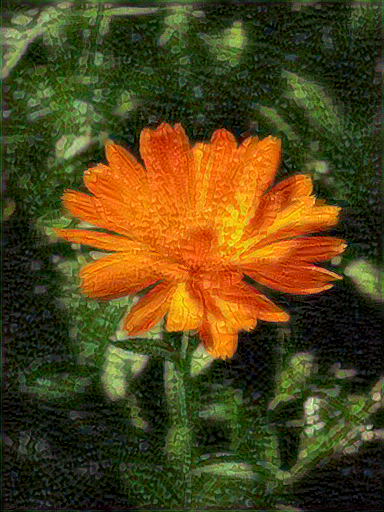

In [19]:
for i in range(10):
    train_step(img)
tensor2img(img)

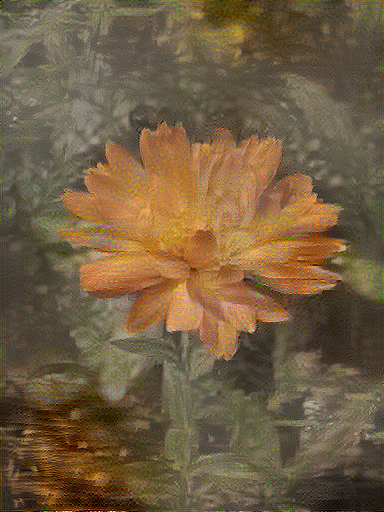

Train step: 1000
Total time: 34.9


In [20]:
start=time.time()
epochs=10; steps_per_epoch=100
step=0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step+=1
        train_step(img)
        print('-',end='')
    clear_output(wait=True)
    display(tensor2img(img))
    print('Train step: {}'.format(step))
end=time.time()
print('Total time: {:.1f}'.format(end-start))

In [21]:
%radial_gradient_header Total Variation Loss

In [22]:
def highpass_xy(img):
    x_var=img[:,:,1:,:]-img[:,:,:-1,:]
    y_var=img[:,1:,:,:]-img[:,:-1,:,:]
    return x_var,y_var

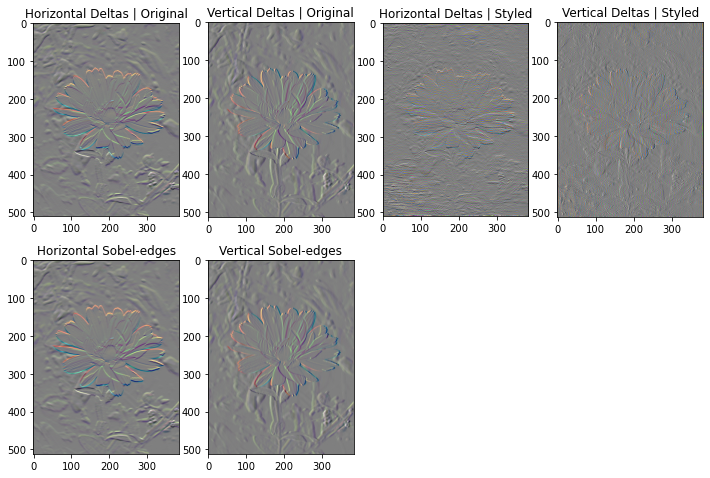

In [23]:
x_deltas,y_deltas=highpass_xy(original_img)
pl.figure(figsize=(12,8))
pl.subplot(2,4,1)
pl.imshow(tf.squeeze(clip01(2*y_deltas+.5)))
pl.title('Horizontal Deltas | Original')
pl.subplot(2,4,2)
pl.imshow(tf.squeeze(clip01(2*x_deltas+.5)))
pl.title('Vertical Deltas | Original')
x_deltas,y_deltas=highpass_xy(img)
pl.subplot(2,4,3)
pl.imshow(tf.squeeze(clip01(2*y_deltas+.5)))
pl.title('Horizontal Deltas | Styled')
pl.subplot(2,4,4)
pl.imshow(tf.squeeze(clip01(2*x_deltas+.5)))
pl.title('Vertical Deltas | Styled')
sobel=tf.image.sobel_edges(original_img)
pl.subplot(2,4,5)
pl.imshow(tf.squeeze(clip01(sobel[...,0]/4+.5)))
pl.title('Horizontal Sobel-edges')
pl.subplot(2,4,6)
pl.imshow(tf.squeeze(clip01(sobel[...,1]/4+.5)))
pl.title('Vertical Sobel-edges');

In [24]:
def total_variation_loss(img):
    x_deltas,y_deltas=highpass_xy(img)
    return tf.reduce_sum(tf.abs(x_deltas))+\
           tf.reduce_sum(tf.abs(y_deltas))
total_variation_loss(img).numpy(),\
tf.image.total_variation(img).numpy()

(73397.516, array([73397.516], dtype=float32))

In [25]:
%radial_gradient_header Train Steps with Total Variation Loss

In [26]:
total_variation_weight=50
img=tf.Variable(original_img)
@tf.function()
def train_step(img,total_variation_weight=total_variation_weight):
    with tf.GradientTape() as tape:
        outputs=extractor(img)
        loss=style_original_loss(outputs)
        loss+=total_variation_weight*tf.image.total_variation(img)
    gradient=tape.gradient(loss,img)
    optimizer.apply_gradients([(gradient,img)])
    img.assign(clip01(img))

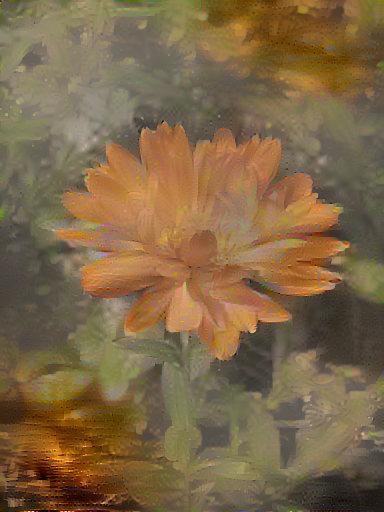

Train step: 1000
Total time: 36.5


In [27]:
start=time.time()
epochs=10; steps_per_epoch=100
step=0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step+=1
        train_step(img)
        print('-',end='')
    clear_output(wait=True)
    display(tensor2img(img))
    print('Train step: {}'.format(step))
end=time.time()
print('Total time: {:.1f}'.format(end-start))